## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


In [3]:
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index <= '12-31-2017')
test_yrs = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index <= '12-31-2006')) | ((asos_snotel_UA_df.index >= '01-01-2017') & (asos_snotel_UA_df.index <= '12-31-2017'))
train_yrs = (asos_snotel_UA_df.index >= '01-01-2007') & (asos_snotel_UA_df.index <= '12-31-2016')

It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2007-2016 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [4]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Variable OLS (CMtn Surface Variables)


In [5]:


OLS_CMtn_Dewpoint = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Dewpoint_degC',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtnSNTL_Temp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtnSNTL_Temp_degC',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_Temperature = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Temperature_degC',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_WindSpeed = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindSpeed_mps',asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_CloudCover = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_CloudCover_oktas', asos_snotel_UA_df[train_yrs]).fit()
OLS_CMtn_WindDirection = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindDirection_deg', asos_snotel_UA_df[train_yrs]).fit()
OLS_LXV_12hr_delta_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_12hr_delta_Pressure_hp', asos_snotel_UA_df[train_yrs]).fit()
OLS_LXV_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_Pressure_hp', asos_snotel_UA_df[train_yrs]).fit()


print(OLS_CMtn_Dewpoint.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtnSNTL_Temp.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Temperature.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindSpeed.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_CloudCover.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindDirection.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_12hr_delta_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")



#['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
#       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
#       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
#       'LXV_Temperature_degC', 'LXV_Dewpoint_degC'


#print(a.rsquared)
#print(a.rsquared_adj)
#print(a.rsquared_adj)
#print(a.fvalue)
#print(a.f_pvalue)
#print(a.pvalues)
print(OLS_CMtn_Dewpoint.params)
#qq=sm.qqplot(a.resid, line='r')



                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.007
Model:                                               OLS   Adj. R-squared:                  0.002
Method:                                    Least Squares   F-statistic:                     1.425
Date:                                   Thu, 07 Mar 2019   Prob (F-statistic):              0.234
Time:                                           19:49:45   Log-Likelihood:                -441.11
No. Observations:                                    210   AIC:                             886.2
Df Residuals:                                        208   BIC:                             892.9
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [6]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[train_yrs][var])
    total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df[train_yrs][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    
    
    


Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

### Now run OLS model with the chosen variables ##

In [7]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df[train_yrs]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df[train_yrs]).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts
0.1305516163913758
KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts
0.1305516

KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts
0.12695821797937612
KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_t

LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts
0.10445283591875765
KGJT_250mb_speed_kts+ LXV_Pressure

KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_7

KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250

KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_

KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_t

KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwp

KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Tem

KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_25

KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+

KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_heigh

KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ K

KGJT_d700_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc

KGJT_d300_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850

KGJT_d300_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_de

CMtn_WindSpeed_mps+ KGJT_d400_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_300mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_4

**Create plot of adjusted R squared**

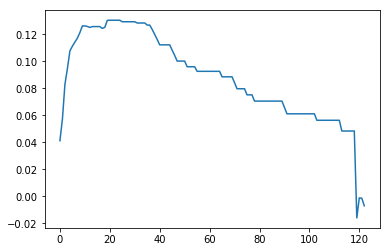

In [8]:
plt.plot(adjRs)

**Create plot of probabilities associated with the F statistic**

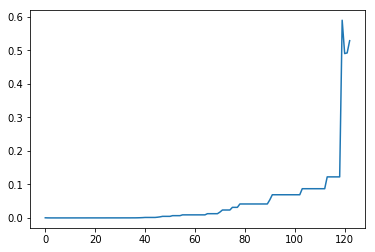

In [9]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [10]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, asos_snotel_UA_df[train_yrs]).fit()



0 KGJT_400mb_speed_kts 
 Adjusted R: 0.041189669333205225  Fstat(prob): 0.0003635502493593034

1 KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 
 Adjusted R: 0.05720142278782048  Fstat(prob): 0.00010268096491353507

2 KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 
 Adjusted R: 0.08280283269137334  Fstat(prob): 6.2161176449009565e-06

3 KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 
 Adjusted R: 0.09473089612489827  Fstat(prob): 2.7176123716749033e-06

4 KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 
 Adjusted R: 0.10776462306988954  Fstat(prob): 1.4119479795736815e-06

5 KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 
 Adjusted R: 0.11132603218253145  Fstat(prob): 1.659446118948009e-06

6 KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_40

25 KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 
 Adjusted R: 0.12943373299160943  Fstat(prob): 0.00011460301992589244

26 KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d70

38 LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 
 Adjusted R: 0.1200094586533248  Fstat(prob): 0.0005669061190079861

39 LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_

47 KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 
 Adjusted R: 0.1002702159001


56 KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_

63 KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200

69 KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_300_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_300_tmpc+ KGJT_d700_400_tmpc+ KGJT_d850_400_height_m+ KGJT_d700_400_height_m+ KGJT_d500_400_tmpc+ K

75 KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_400mb_dwpc+ KGJT_300mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500

80 KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_Temperature_degC+ LXV_WindDirection_deg+ KGJT_d250_200_speed_kts+ KGJT_d700_200_drct+ KGJT_200mb_drct+ KGJT_250mb_

85 KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT_250mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_500mb_dwpc+ KGJT_d500_200_dwpc+ LXV_

90 KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_250mb_speed_kts+ LXV_Pressure_hp+ KGJT

95 KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_height_m+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_200mb_speed_k

99 KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_height_m+ KGJT_d850_200_he

103 KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d500_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_250_tmp

107 KGJT_d700_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_d850_300_height_m+ KGJT_d700_300_height_m+ KGJT_d300_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_200mb_

111 KGJT_d300_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d300_200_height_m+ KGJT_d400_300_height_m+ KGJT_d500_300_height_m+ KGJT_

115 KGJT_d300_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_500mb_speed_kts+ CMtnSNTL_Tem

119 CMtn_WindSpeed_mps+ KGJT_d400_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_300mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_300_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d700_250_drct+ KGJT_400mb_drct+ KGJT_d700_300_drct+ KGJT_d300_200_drct+ KGJT_d700_400_drct+ KGJT_250mb_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_d400_200_drct+ KGJT_300mb_drct+ KGJT_d250_200_drct+ KGJT_d500_200_drct+ KGJT_d700_300_speed_kts+ KGJT_400mb_height_m+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d850_250_height_m+ KGJT_500mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_300mb_height_m+ KGJT_200mb_height_m+ KGJT_700mb_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d400_300_drct+ KGJT_d500_200_speed_kts+ KGJT_d5

**Find max adj R and obtain OLS summary**

In [11]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts


In [12]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , asos_snotel_UA_df[train_yrs]).fit() 
print(maxOLS_all.summary())


KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.194
Model:                                               OLS   Adj. R-squared:                  0.131
Method:                                    Least Squares   F-statistic:                     3.058
Date:                                   Thu, 07 Mar 2019   Prob (F-statistic):           8.12e-05
Time:                               

**Print QQ plot**

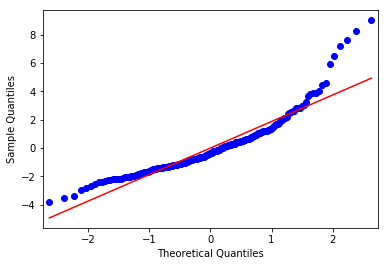

In [13]:
qq2=sm.qqplot(maxOLS_all.resid, line='r')

**There are a few variables with P|t| values which are high, indicative of high randomness. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results**

In [14]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str, asos_snotel_UA_df[train_yrs]).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str, asos_snotel_UA_df[train_yrs]).fit() 
print(maxOLS_goodp.summary())


KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts
1
KGJT_d500_400_tmpc+ KGJT_d500_250_drct+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc 0.0028268849816539543 0.01
0.0028268849816539543 0.01
2
KGJT_d500_400_tmpc+ KGJT_d500_250_drct+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc 0.0028268849816539543 0.02
3
KGJT_d500_400_tmpc+ KGJT_d400_250_dwpc+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m 0.0861681749605232 0.03
0.0861681749605232 0.03
4
KGJT_d500_400_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ 

KGJT_d500_400_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 0.13125882880553918 0.27
0.13125882880553918 0.27
28
KGJT_d500_400_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 0.13125882880553918 0.28
29
KGJT_d500_400_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400m

KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 0.13055161639137514 0.48
49
KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 0.13055161639137514 0.49
50
KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tm

KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 0.1305516163913718 0.8300000000000001
84
KGJT_d500_400_tmpc+ KGJT_d850_500_height_m+ LXV_WindSpeed_mps+ KGJT_500mb_tmpc+ KGJT_d700_500_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_d700_250_dwpc+ LXV_Dewpoint_degC+ KGJT_400mb_tmpc+ KGJT_d700_400_dwpc+ KGJT_d700_300_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_dwpc+ KGJT_d300_250_drct+ KGJT_d250_200_tmpc+ KGJT_d500_400_height_m+ KGJT_400mb_speed_kts 0.1305516163913718 0.84
85
KGJT_d500_400_tmpc+ KGJT

**No improvement to P|t| could be made**

## Try fit parameters with test dataset (2016 and 2017 data)

In [15]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
sd_missings =[]
print(variables)
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[test_yrs][var])
    total_poss = len(asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df[test_yrs][idx])
    
    sd_missings.append(total_avail/total_poss)
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    

from tabulate import tabulate

tbl = zip(variables,sd_missings)  
    
print(tabulate(tbl, headers=['Var',  '%Missing'], tablefmt='github'))


['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_85

count    55.000000
mean      4.709091
std       2.439435
min       3.000000
25%       3.000000
50%       4.000000
75%       5.000000
max      16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64
count    53.000000
mean      4.918869
std       0.852281
min       2.477813
25%       4.378178
50%       4.973188
75%       5.474730
max       6.628477
dtype: float64
55


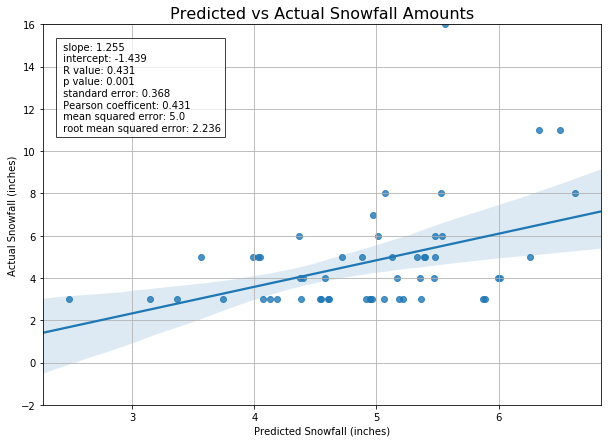

In [34]:
fig = plt.figure(figsize=(10,7))



#Define actual and predicted snowfall dataframes
actual_snf = asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict = maxOLS_goodp.predict(asos_snotel_UA_df[test_yrs][asos_snotel_UA_df[test_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])
print(actual_snf.describe())
print(predict.describe())


#Do linear regression and calcuate relevent stats

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


idx = np.isfinite(predict) & np.isfinite(actual_snf) 
print(len(idx))

#print(asos_snotel_UA_df[test_yrs][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3].describe())


## Do linear regression and calculate slope, intercept, r, p, std err
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(predict[idx], actual_snf[idx])
#Calculate mse and rmse
mse = mean_squared_error(actual_snf[idx].values,predict[idx].values)
rmse = np.sqrt(mse)
pearson1, pv = pearsonr(predict[idx], actual_snf[idx])

#plot and annotate
sns.regplot(predict[idx].values, actual_snf[idx].values)
bbox_props=dict(facecolor='red', alpha=0.75, fc = 'white')
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n standard error: ' + str(round(std_err1,3)) +
                 '\n Pearson coefficent: ' + str(round(pearson1,3)) +
                 '\n mean squared error: ' + str(round(mse,3)) +
                 '\n root mean squared error: ' + str(round(rmse,3)), \
                 xy=(0.03, 0.72), xycoords='axes fraction', fontsize=10, bbox = bbox_props)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
#plt.xlim([3,6])
plt.ylim([-2,16])
plt.grid(True)
plt.title('Predicted vs Actual Snowfall Amounts', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/pred_vs_act_UASFC.png',bbox_inches='tight')

[4.71879397 3.98887253 5.16642618 4.88304611 4.04286265 4.9731879
 6.01262228 4.37081695 5.35953019 4.37817823 4.39661548 5.07350249
 5.12933229 5.52598805 5.21679654 5.48201202 6.32982272 4.61244394
 5.53612637 3.73832434 4.12575631 5.99412788 4.54419547 5.38731071
 5.397954   5.87248304 5.89225547 5.47714265 6.2570737  5.01566235
 4.5779739  3.36633011 3.14380535 4.54048723 4.03025269 4.60130021
 4.94319131 5.18723233 5.47473044 5.06138909 4.18199601 2.4778131
 5.36701428 4.91213638 5.33589642 4.06708762 5.55876161 4.36328334
 6.50704323 4.94954121 6.62847712 4.96680087 3.5582386 ]
[ 5.  5.  4.  5.  5.  7.  4.  4.  4.  3.  4.  8.  5.  8.  3.  6. 11.  3.
  6.  3.  3.  4.  3.  5.  5.  3.  3.  5.  5.  6.  4.  3.  3.  3.  5.  3.
  3.  3.  4.  3.  3.  3.  3.  3.  5.  3. 16.  6. 11.  3.  8.  3.  5.]


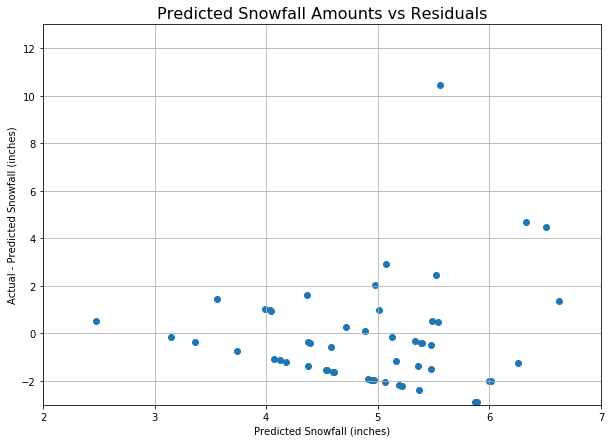

In [23]:
fig = plt.figure(figsize=(10,7))

plt.scatter(predict[idx].values, actual_snf[idx].values-predict[idx].values)
print(predict[idx].values)
print(actual_snf[idx].values)
#print(actual_snf[idx].values-predict[idx].values)

plt.ylabel('Actual - Predicted Snowfall (inches)')
plt.xlabel('Predicted Snowfall (inches)')
plt.xlim([2,7])
plt.ylim([-3,13])
plt.grid(True)
plt.title('Predicted Snowfall Amounts vs Residuals', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/resid_vs_pred_UASFC.png',bbox_inches='tight')

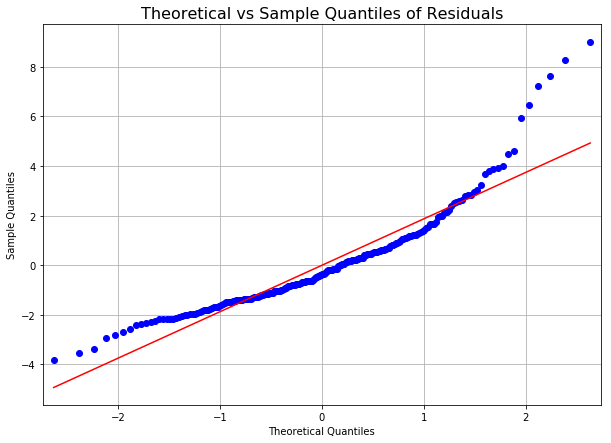

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
qq2=sm.qqplot( maxOLS_testgoodp.resid, line='r', ax = ax)
plt.title('Theoretical vs Sample Quantiles of Residuals', fontsize = 16)
plt.grid(True)
plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/qq_resid_UASFC.png',bbox_inches='tight')

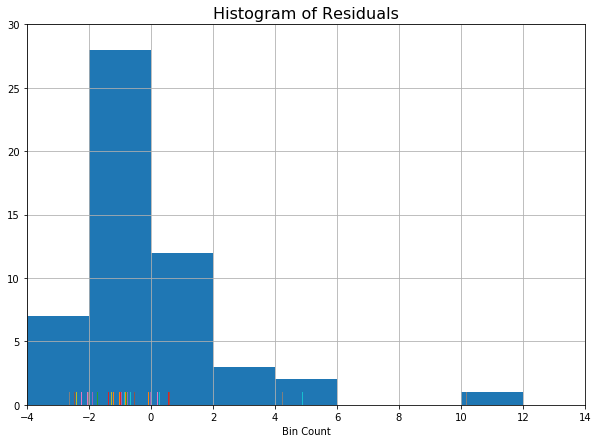

In [29]:

diff = actual_snf[idx].values-predict[idx].values
diff_df = pd.DataFrame(diff)

#fig = plt.figure(figsize=(10,7))
hist = diff_df.hist(figsize=(10,7), bins = [-4,-2,0,2,4,6,8,10,12,14])
plt.hist(diff_df)
plt.xlabel('Actual - Predicted Snowfall (inches)')
plt.xlabel('Bin Count')
plt.xlim([-4,14])
plt.ylim([0,30])
#plt.grid(True)
plt.title('Histogram of Residuals', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/MS_CS_report/figs/hist_actual_minus_pred_UASFC.png',bbox_inches='tight')